In [71]:
import numpy as np
import pandas as pd

In [72]:
data = pd.read_csv("../datasets/cleaned_data.csv")

In [73]:

cat_cols = ["Wall_Construction_Material", "Boiler", "Own_Type", "Climate_Zone"]
cont_cols = ["SQFT", "Number_Workers", "Building_Activity","Work_hours", "Cooling_Days", "Number_desktops", "Electricity_Consumption"]
target_col = "Electricity_Consumption"
columns =  cat_cols + cont_cols

In [124]:
def show_unique_values(df, cat_cols, verbose = True):
        """
        Prints the unique values for each categorical column in the DataFrame.
        
        Args:
        - df: DataFrame to inspect.
        - cat_cols: List of categorical column names.
        """
        if verbose : 
            print("-----------------[ Unique Values in Categorical Columns ]-----------------")
            for col in cat_cols:
                unique_vals = df[col].dropna().unique()  # Drop NaN values to exclude them
                print(f"{col}: {unique_vals.tolist()}")
                print(f"Total Unique (excluding NaN): {len(unique_vals)}\n")


def dataSummary(df, cat_cols, cont_cols , verbose = True):
    if verbose:
        print("------------------------[ Shape ]------------------------\n", df.shape)
        print("------------------------[ Head ]------------------------\n",df.head)
        print("------------------------[ Columns ]------------------------\n",df.columns)
        print("------------------------[ describe ]------------------------\n",df.describe())
        missing_values = df.isnull().sum()
        print("------------------------[ Missing ]------------------------\n", missing_values)
        unique_counts = df.apply(lambda col: col.nunique(dropna=True))
        print("------------------------[ Unique Count ]------------------------\n", unique_counts)
        show_unique_values(df,cat_cols, verbose)
    
    
dataSummary(data[columns], cat_cols, cont_cols, True)
df = data[columns]

------------------------[ Shape ]------------------------
 (6436, 11)
------------------------[ Head ]------------------------
 <bound method NDFrame.head of       Wall_Construction_Material  Boiler  Own_Type  Climate_Zone      SQFT  \
0                            1.0     2.0       8.0           3.0  210000.0   
1                            1.0     2.0       2.0           4.0   28000.0   
2                            1.0     2.0       3.0           4.0    2100.0   
3                            2.0     1.0       1.0           5.0  240000.0   
4                            3.0     2.0       1.0           3.0  295000.0   
...                          ...     ...       ...           ...       ...   
6431                         1.0     1.0       9.0           2.0  130000.0   
6432                         1.0     2.0       1.0           4.0    1050.0   
6433                         2.0     2.0       2.0           4.0  122000.0   
6434                         3.0     2.0       3.0           4

In [125]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


def round_to_nearest_category(df, cat_cols, category_map):
    """
    Rounds imputed values in categorical columns to the nearest valid category.
    
    Args:
    - df: DataFrame with imputed values.
    - cat_cols: List of categorical column names.
    - category_map: Dictionary with column names as keys and valid categories as values.
    
    Returns:
    - DataFrame with corrected categorical columns.
    """
    for col in cat_cols:
        valid_categories = np.array(category_map[col])
        df[col] = df[col].apply(lambda x: valid_categories[np.abs(valid_categories - x).argmin()])
    return df

def DataPreProcessing(df, cat_cols, cont_cols, category_map):
    
    df = df.dropna(subset=[target_col]).copy()
    imputer = KNNImputer(n_neighbors=15)
    df_imputed = pd.DataFrame(imputer.fit_transform(df[cat_cols + cont_cols]), columns=cat_cols + cont_cols)
    df_imputed = round_to_nearest_category(df_imputed, cat_cols, category_map)
    
    scaler = MinMaxScaler()
    # scaler = StandardScaler()
    
    df_imputed[cont_cols] = scaler.fit_transform(df_imputed[cont_cols])

    return df_imputed, scaler


def DataPreProcessingMedianMode(df, cat_cols, cont_cols):
    """
    Preprocesses data by handling missing values:
    - Fills continuous columns with the median.
    - Fills categorical columns with the mode.
    - Normalizes continuous columns.

    Args:
    - df: DataFrame to process.
    - cat_cols: List of categorical column names.
    - cont_cols: List of continuous column names.

    Returns:
    - df_processed: DataFrame after preprocessing.
    - scaler: Fitted scaler object for continuous columns.
    """
    df_processed = df.copy()
    
    for col in cont_cols:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
    
    for col in cat_cols:
        mode_val = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_val, inplace=True)
    
    scaler = MinMaxScaler()
    df_processed[cont_cols] = scaler.fit_transform(df_processed[cont_cols])

    return df_processed, scaler

category_map = {
    "Wall_Construction_Material": [1.0, 2.0, 3.0, 5.0, 6.0, 8.0, 4.0, 7.0],
    "Boiler": [2.0, 1.0],
    "Own_Type": [8.0, 2.0, 3.0, 1.0, 10.0, 5.0, 9.0, 97.0, 4.0, 6.0, 7.0],
    "Climate_Zone": [3.0, 4.0, 5.0, 2.0, 7.0, 1.0]
}


df_imputed, scaler = DataPreProcessing(df, cat_cols, cont_cols, category_map)

dataSummary(df_imputed, cat_cols, cont_cols)

------------------------[ Shape ]------------------------
 (6436, 11)
------------------------[ Head ]------------------------
 <bound method NDFrame.head of       Wall_Construction_Material  Boiler  Own_Type  Climate_Zone      SQFT  \
0                            1.0     2.0       8.0           3.0  0.099571   
1                            1.0     2.0       2.0           4.0  0.012863   
2                            1.0     2.0       3.0           4.0  0.000524   
3                            2.0     1.0       1.0           5.0  0.113863   
4                            3.0     2.0       1.0           3.0  0.140066   
...                          ...     ...       ...           ...       ...   
6431                         1.0     1.0       9.0           2.0  0.061457   
6432                         1.0     2.0       1.0           4.0  0.000023   
6433                         2.0     2.0       2.0           4.0  0.057646   
6434                         3.0     2.0       3.0           4

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

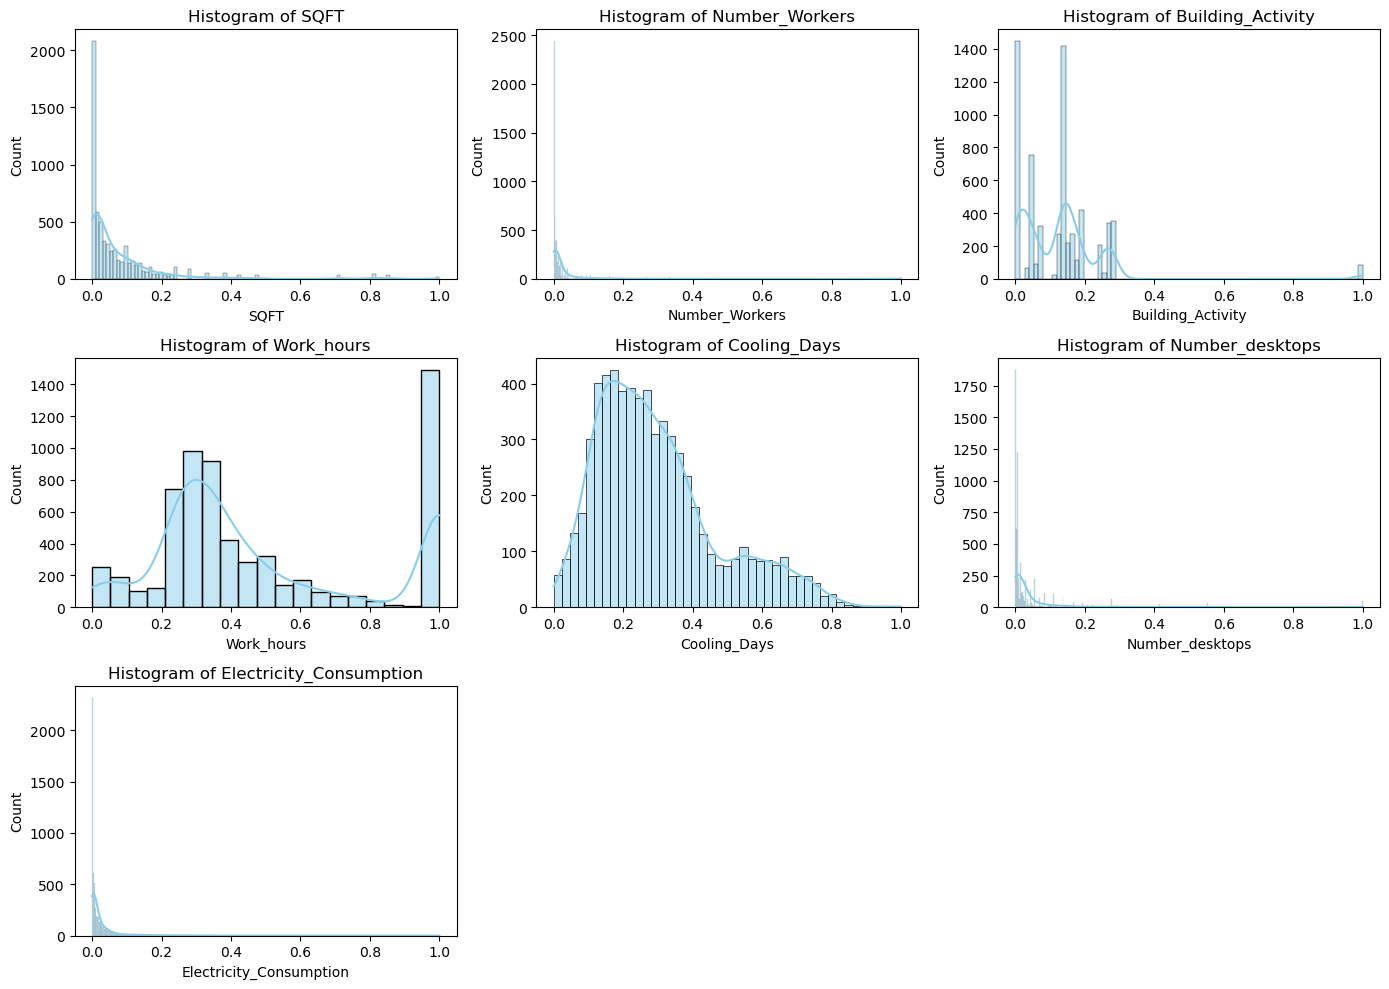

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

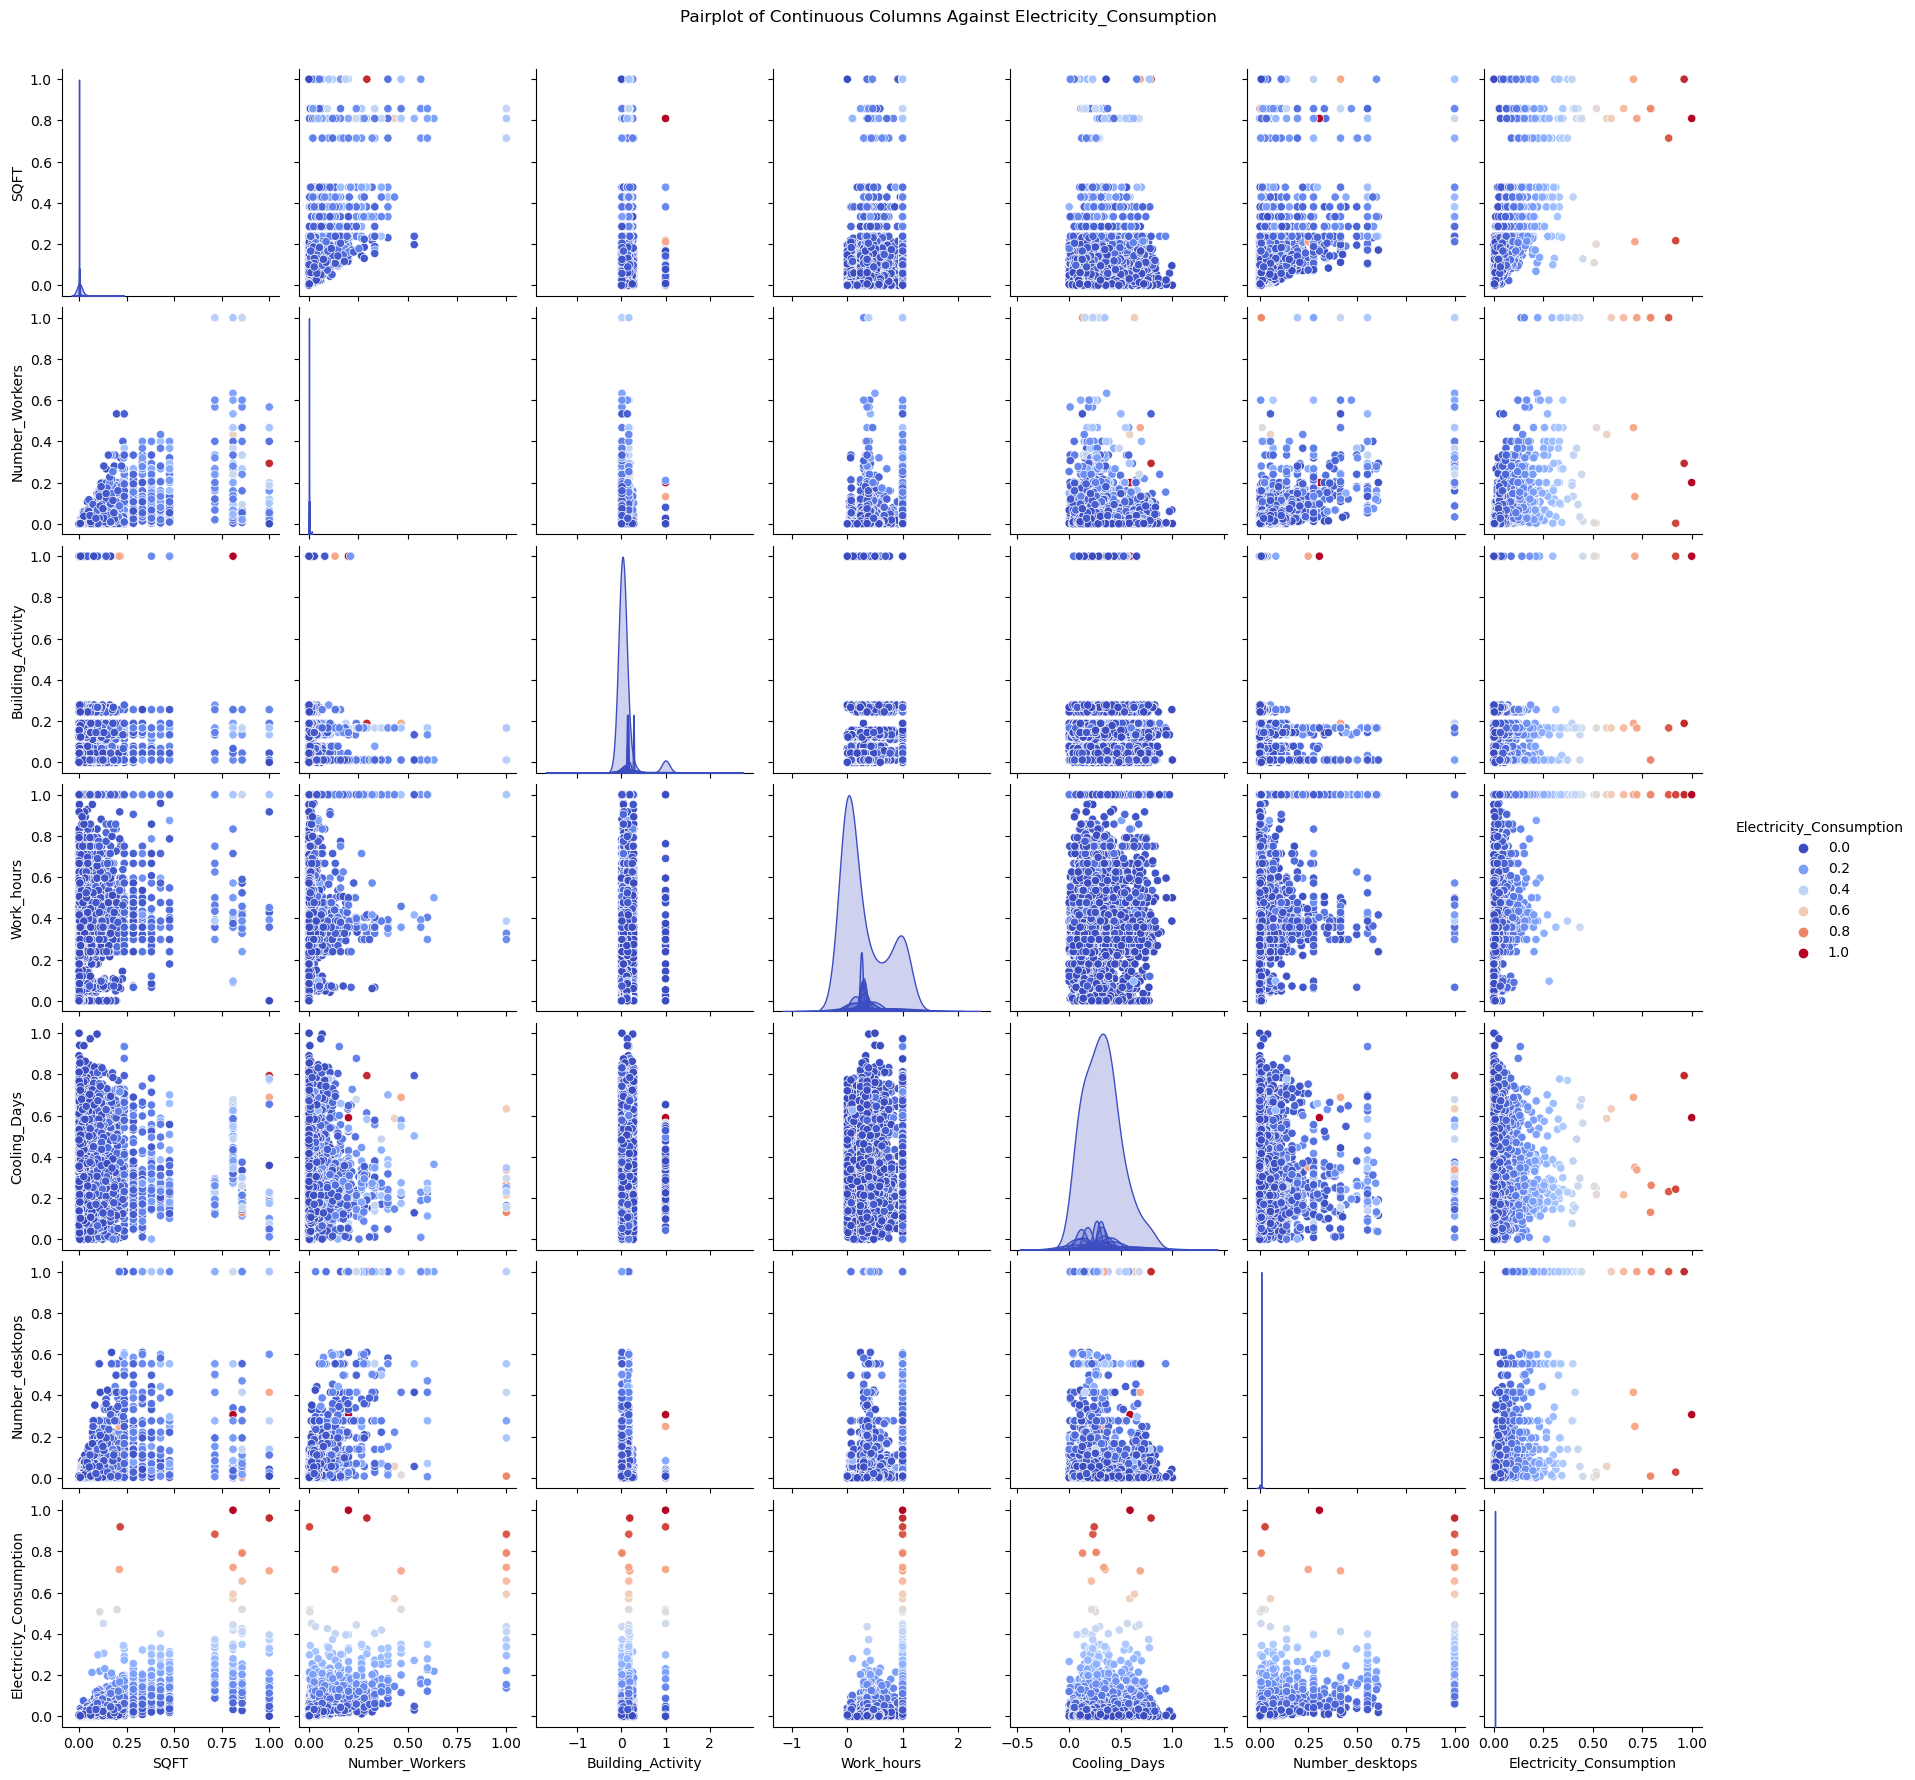

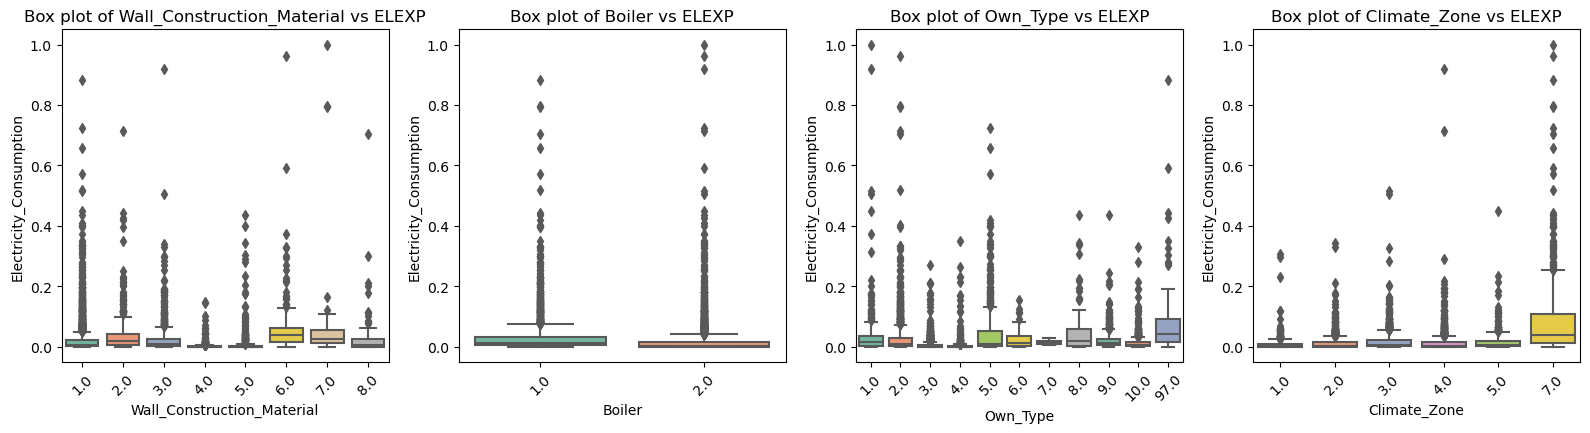

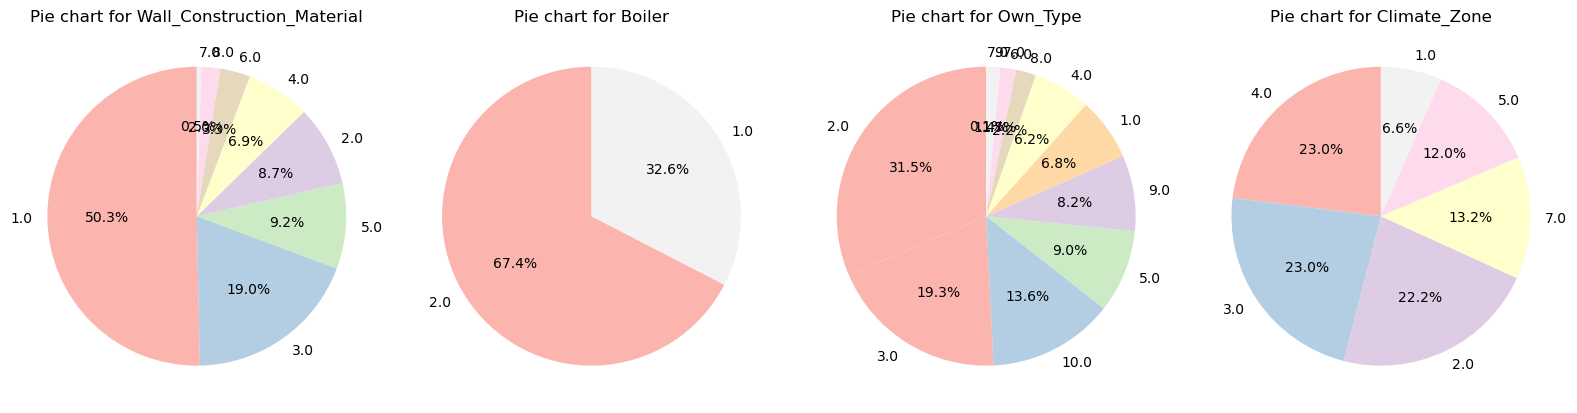

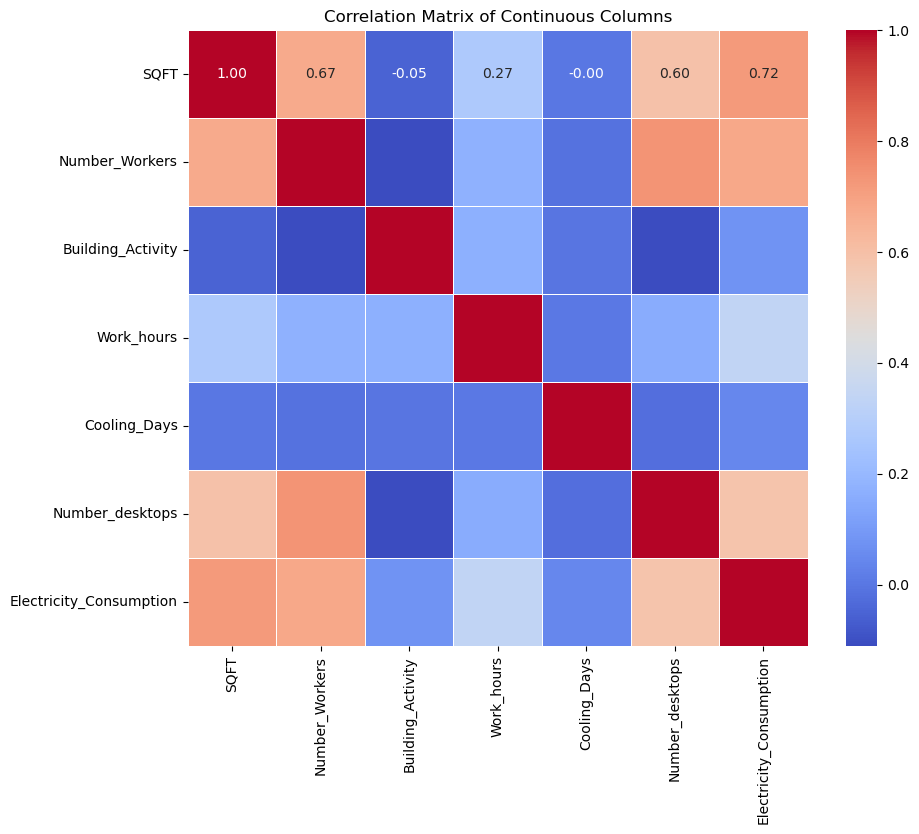

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

class DataExploration:
    def __init__(self, df, cat_cols, cont_cols, target_col):
        self.df = df.copy()
        self.cat_cols = cat_cols
        self.cont_cols = cont_cols
        self.target_col = target_col

    # 1. Plot Histograms for continuous columns
    def freedman_diaconis_bins(self, data):
        """Calculate optimal bin size using the Freedman-Diaconis rule"""
        data = data.replace([np.inf, -np.inf], np.nan).dropna()
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        n = len(data)
        bin_width = 2 * iqr / n**(1/3)
        
        if bin_width == 0:
            return 1  # Default to 1 bin if bin_width is zero
        
        bins = int((data.max() - data.min()) / bin_width)
        return bins


    def plot_histograms(self):
        plt.figure(figsize=(14, 10))
        for i, col in enumerate(self.cont_cols):
            
            bins = self.freedman_diaconis_bins(self.df[col].dropna())
            
            plt.subplot(3, 3, i + 1)
            sns.histplot(self.df[col], kde=True, bins=bins, color='skyblue')
            plt.title(f'Histogram of {col}')
        
        plt.tight_layout()
        plt.show()

    # 2. Pair plot for continuous columns vs ELEXP
    def plot_pairplot(self):
        sns.pairplot(self.df, vars=self.cont_cols, hue=self.target_col, palette='coolwarm')
        plt.suptitle(f"Pairplot of Continuous Columns Against {target_col}", y=1.02)
        plt.show()

    # 3. Box plot for categorical columns vs ELEXP
    def plot_boxplots(self):
        plt.figure(figsize=(16, 12))
        for i, col in enumerate(self.cat_cols):
            plt.subplot(3, 4, i + 1)
            sns.boxplot(x=self.df[col], y=self.df[self.target_col], palette='Set2')
            plt.title(f'Box plot of {col} vs ELEXP')
            plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 4. Pie charts for categorical columns
    def plot_pie_charts(self):
        plt.figure(figsize=(16, 12))
        for i, col in enumerate(self.cat_cols):
            plt.subplot(3, 4, i + 1)
            self.df[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
            plt.title(f'Pie chart for {col}')
            plt.ylabel('')
        plt.tight_layout()
        plt.show()

    # 5. Correlation matrix for continuous columns
    def plot_correlation_matrix(self):
        corr_matrix = self.df[self.cont_cols].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title("Correlation Matrix of Continuous Columns")
        plt.show()

    # Combine all EDA functions into one call
    def perform_eda(self):
        self.plot_histograms()
        self.plot_pairplot()
        self.plot_boxplots()
        self.plot_pie_charts()
        self.plot_correlation_matrix()



import numpy as np

def remove_outliers(df):
    """
    Removes outliers in each column of the DataFrame using the IQR method.

    Args:
    - df: DataFrame from which outliers need to be removed.

    Returns:
    - df_no_outliers: DataFrame with outliers removed.
    """
    df_no_outliers = df.copy()
    
    for col in df_no_outliers.select_dtypes(include=np.number).columns:
        Q1 = df_no_outliers[col].quantile(0.25)
        Q3 = df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
    
    print(f"Shape of the data after removing outliers: {df_no_outliers.shape}")
    return df_no_outliers


# df_imputed[["ELCNS"]] = remove_outliers(df_imputed[["ELCNS"]])

eda = DataExploration(df_imputed, cat_cols, cont_cols, target_col=target_col)

eda.perform_eda()


In [127]:
import pandas as pd

def one_hot_encode(df, cat_cols, target_col):
    """
    Performs one-hot encoding on specified categorical columns and converts boolean to 1 and 0.

    Args:
    - df: DataFrame to encode.
    - cat_cols: List of categorical column names to one-hot encode.
    - target_col: The target column to exclude from encoding.

    Returns:
    - df_encoded: DataFrame with one-hot encoded columns (0 and 1).
    """
    df = df.copy()
    
    cat_cols = [col for col in cat_cols if col != target_col]
    
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    
    for col in df_encoded.columns:
        if df_encoded[col].dtype == bool:
            df_encoded[col] = df_encoded[col].astype(int)

    print(f"Shape after one-hot encoding: {df_encoded.shape}")
    
    return df_encoded

df_encoded = one_hot_encode(df_imputed, cat_cols, target_col)
df_encoded[target_col]

Shape after one-hot encoding: (6436, 30)


0       0.048214
1       0.003939
2       0.000135
3       0.005087
4       0.003326
          ...   
6431    0.006063
6432    0.006114
6433    0.030292
6434    0.002475
6435    0.032954
Name: Electricity_Consumption, Length: 6436, dtype: float64

In [149]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def feature_engineering(df, cat_cols, cont_cols, target_colm, poly_degree = 1):
    """
    Enhances a DataFrame by adding interaction terms, log, and polynomial transformations
    for the continuous columns, while leaving the target column unchanged.

    Args:
    - df: DataFrame to process.
    - cat_cols: List of categorical column names.
    - cont_cols: List of continuous column names.
    - target_col: Name of the target column (to remain unchanged).

    Returns:
    - df_transformed: DataFrame with new features added.
    """
    df_transformed = df.copy()
    
    cont_cols_no_target = [col for col in cont_cols if col != target_col]
    
    # for col1, col2 in combinations(cont_cols_no_target, 2):
    #     interaction_col_name = f"{col1}_x_{col2}"
    #     df_transformed[interaction_col_name] = df_transformed[col1] * df_transformed[col2]
    
    for col in cont_cols_no_target:
        log_col_name = f"log_{col}"
        df_transformed[log_col_name] = np.log1p(df_transformed[col])  # Use log1p to avoid log(0) errors
    
    poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
    poly_features = poly.fit_transform(df_transformed[cont_cols_no_target])
    poly_feature_names = poly.get_feature_names_out(cont_cols_no_target)
    
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_transformed.index)
    df_transformed = pd.concat([df_transformed, poly_df], axis=1)
    
    df_transformed[target_col] = df[target_col]
    
    # print(f"Shape after feature engineering: {df_transformed.shape}")
    return df_transformed

df_transformed = feature_engineering(df_encoded, cat_cols, cont_cols, target_col,2)

In [150]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def run_ols(df, target_col, verbose= True):
    """
    Runs an OLS regression and finds significant features based on p-values.
    
    Args:
    - df_encoded: DataFrame containing encoded features and target column.
    - target_col: The name of the target column (dependent variable).
    
    Returns:
    - significant_features: List of features that are statistically significant.
    """
    X = df.drop(columns=[target_col])  # Features
    y = df[target_col]  # Target variable
    
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)
    y = y.loc[X.index]  # Align target column with cleaned X
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    summary = model.summary()
    if verbose: print(summary)
    
    p_values = model.pvalues
    significant_features = p_values[p_values < 0.05].index.tolist()
    
    if 'const' in significant_features:
        significant_features.remove('const')
    
    return significant_features

significant_features = run_ols(df_transformed, target_col, True)
print(f"Significant features: {significant_features}")


                               OLS Regression Results                              
Dep. Variable:     Electricity_Consumption   R-squared:                       0.770
Model:                                 OLS   Adj. R-squared:                  0.768
Method:                      Least Squares   F-statistic:                     381.8
Date:                     Sat, 30 Nov 2024   Prob (F-statistic):               0.00
Time:                             15:43:38   Log-Likelihood:                 14130.
No. Observations:                     6436   AIC:                        -2.815e+04
Df Residuals:                         6379   BIC:                        -2.776e+04
Df Model:                               56                                         
Covariance Type:                 nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [151]:
X_train, X_test, y_train, y_test = train_test_split(
    df_transformed[significant_features], df_transformed[target_col], test_size=0.2, random_state=42
)

Final MSE loss: 0.0008


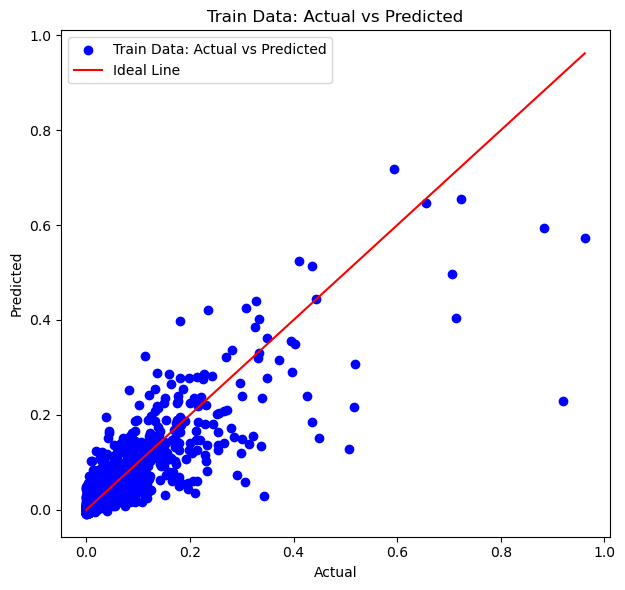

Train Accuracy: R2 = 0.7520, MSE = 0.0008
Test Accuracy: R2 = 0.7485, MSE = 0.0007


(0.7519918588756195,
 0.0008344584155650055,
 0.7484877581016014,
 0.0006961804089059028)

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

class LinearRegressionModel:
    def __init__(self, df, target_col):
        """
        Initialize the model with data and columns.
        df: DataFrame, data including both features and target
        target_col: str, the name of the target column (dependent variable)
        cat_cols: list, categorical columns (if any)
        cont_cols: list, continuous columns (if any)
        """
        self.df = df
        self.target_col = target_col
        
        self.X = self.df.drop(columns=[self.target_col])
        self.y = self.df[target_col]
        
        self.model = LinearRegression()
        
    def fit(self, X_train, y_train):
        """
        Fit the linear regression model using sklearn's LinearRegression.
        X_train: Features for training
        y_train: Target variable for training
        """
        self.model.fit(X_train, y_train)
        
    def predict(self, X):
        """
        Predict the target variable for a given input matrix X.
        """
        return self.model.predict(X)

    def plot_metrics(self, X_train, y_train):
        """
        Plot loss over epochs and Test vs Predicted values.
        """
        train_pred = self.predict(X_train)
        
        loss = mean_squared_error(y_train, train_pred)
        print(f'Final MSE loss: {loss:.4f}')
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(y_train, train_pred, color='blue', label='Train Data: Actual vs Predicted')
        plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', label='Ideal Line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Train Data: Actual vs Predicted')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def accuracy(self, X_train, y_train, X_test, y_test):
        """
        Calculate the R2, MSE, and Accuracy (train and test).
        """
        train_pred = self.predict(X_train)
        train_r2 = r2_score(y_train, train_pred)
        train_mse = mean_squared_error(y_train, train_pred)
        
        test_pred = self.predict(X_test)
        test_r2 = r2_score(y_test, test_pred)
        test_mse = mean_squared_error(y_test, test_pred)

        print(f'Train Accuracy: R2 = {train_r2:.4f}, MSE = {train_mse:.4f}')
        print(f'Test Accuracy: R2 = {test_r2:.4f}, MSE = {test_mse:.4f}')
        
        return train_r2, train_mse, test_r2, test_mse




model = LinearRegressionModel(df_transformed, target_col)
model.fit(X_train, y_train)

model.plot_metrics(X_train, y_train)
model.accuracy(X_train, y_train, X_test, y_test)


Train Metrics:
MSE: 0.0009
MAE: 0.0113
R2: 0.7347
Adjusted R2: 0.7332
MAPE: 8724198.6781%

Test Metrics:
MSE: 0.0007
MAE: 0.0106
R2: 0.7445
Adjusted R2: 0.7419
MAPE: 593.2032%



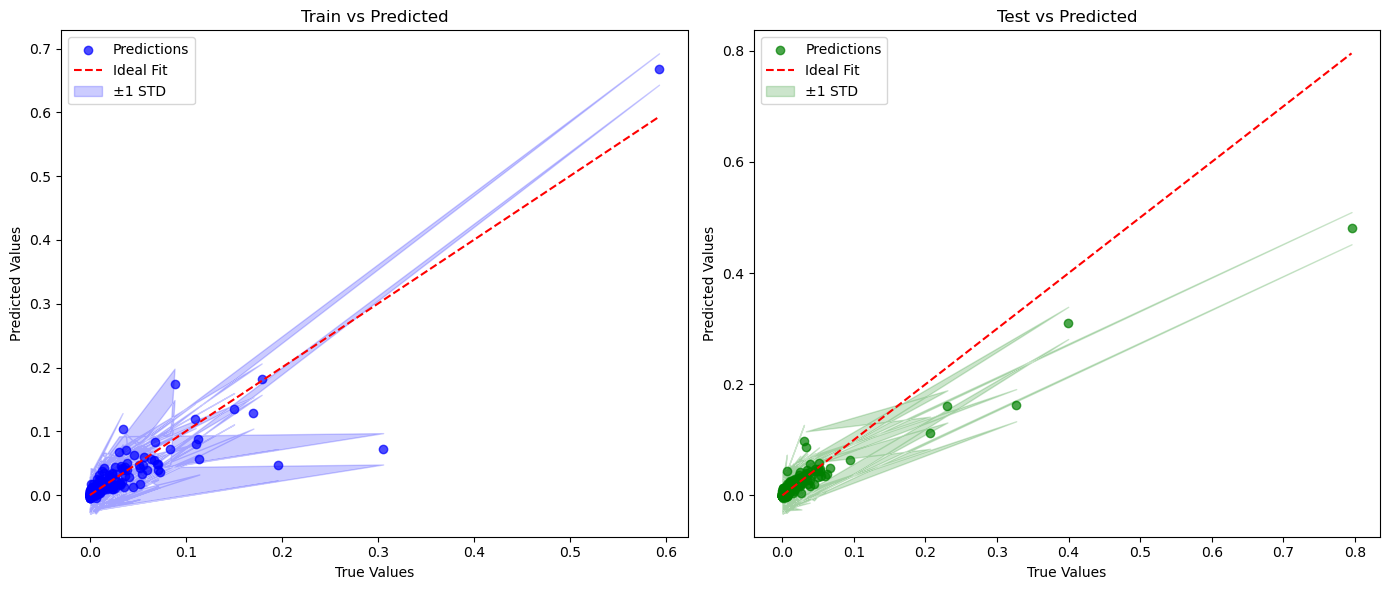

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

class RidgeModel:
    def __init__(self, alpha=1.0):
        """
        Initialize the Ridge regression model.
        
        Args:
        - alpha (float): Regularization strength (default is 1.0).
        """
        self.alpha = alpha
        self.model = Ridge(alpha=self.alpha)

    def train(self, X_train, y_train):
        """
        Train the Ridge regression model on the training data.
        
        Args:
        - X_train (DataFrame): The feature matrix for training.
        - y_train (Series): The target variable for training.
        """
        self.model.fit(X_train, y_train)

    def predict(self, X):
        """
        Make predictions using the trained Ridge regression model.
        
        Args:
        - X (DataFrame): The feature matrix for which predictions are made.
        
        Returns:
        - y_pred (array): The predicted values.
        """
        return self.model.predict(X)

    def evaluate(self, X_train, y_train, X_test, y_test, verbose= True):
        """
        Evaluate the model's performance on both train and test datasets.
        
        Args:
        - X_train (DataFrame): The feature matrix for training.
        - y_train (Series): The target variable for training.
        - X_test (DataFrame): The feature matrix for testing.
        - y_test (Series): The target variable for testing.
        
        Prints:
        - MSE, MAE, R2, Adjusted R2, and MAPE.
        """
        
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)
        n_train = X_train.shape[0]
        p_train = X_train.shape[1]
        adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
        
        mse_test = mean_squared_error(y_test, y_test_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        n_test = X_test.shape[0]
        p_test = X_test.shape[1]
        adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)
        
        mape_train = np.mean(np.abs((y_train - y_train_pred) / (y_train + 1e-10))) * 100  # Add small epsilon to avoid division by zero
        mape_test = np.mean(np.abs((y_test - y_test_pred) / (y_test + 1e-10))) * 100  # Add small epsilon to avoid division by zero
        if verbose:
            print("Train Metrics:")
            print(f"MSE: {mse_train:.4f}")
            print(f"MAE: {mae_train:.4f}")
            print(f"R2: {r2_train:.4f}")
            print(f"Adjusted R2: {adjusted_r2_train:.4f}")
            print(f"MAPE: {mape_train:.4f}%\n")
            
            print("Test Metrics:")
            print(f"MSE: {mse_test:.4f}")
            print(f"MAE: {mae_test:.4f}")
            print(f"R2: {r2_test:.4f}")
            print(f"Adjusted R2: {adjusted_r2_test:.4f}")
            print(f"MAPE: {mape_test:.4f}%\n")
        return mse_train, mse_test, r2_train, r2_test

    
    def plot_predictions(self, X_train, y_train, X_test, y_test):
        """
        Plot train vs predicted and test vs predicted values with variability reference.
        
        Args:
        - X_train (DataFrame): The feature matrix for training.
        - y_train (Series): The target variable for training.
        - X_test (DataFrame): The feature matrix for testing.
        - y_test (Series): The target variable for testing.
        """
        # Predictions
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)
        
        # Calculate residuals and variability
        train_residuals = y_train - y_train_pred
        test_residuals = y_test - y_test_pred
        train_std = train_residuals.std()
        test_std = test_residuals.std()
        
        # Plot Train vs Predicted with Variability
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(y_train, y_train_pred, color='blue', alpha=0.7, label='Predictions')
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Ideal Fit')
        plt.fill_between(y_train, y_train_pred - train_std, y_train_pred + train_std, color='blue', alpha=0.2, label='±1 STD')
        plt.title("Train vs Predicted")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        
        # Plot Test vs Predicted with Variability
        plt.subplot(1, 2, 2)
        plt.scatter(y_test, y_test_pred, color='green', alpha=0.7, label='Predictions')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
        plt.fill_between(y_test, y_test_pred - test_std, y_test_pred + test_std, color='green', alpha=0.2, label='±1 STD')
        plt.title("Test vs Predicted")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        
        plt.tight_layout()
        plt.show()



ridge_model = RidgeModel(alpha=1.0)
ridge_model.train(X_train, y_train)

mse_train, mse_test, r2_train, r2_test = ridge_model.evaluate(X_train, y_train, X_test, y_test ,True)
n_for_plot = 200


ridge_model.plot_predictions(X_train[:n_for_plot], y_train[:n_for_plot], X_test[:n_for_plot], y_test[:n_for_plot])


### Manual tuning

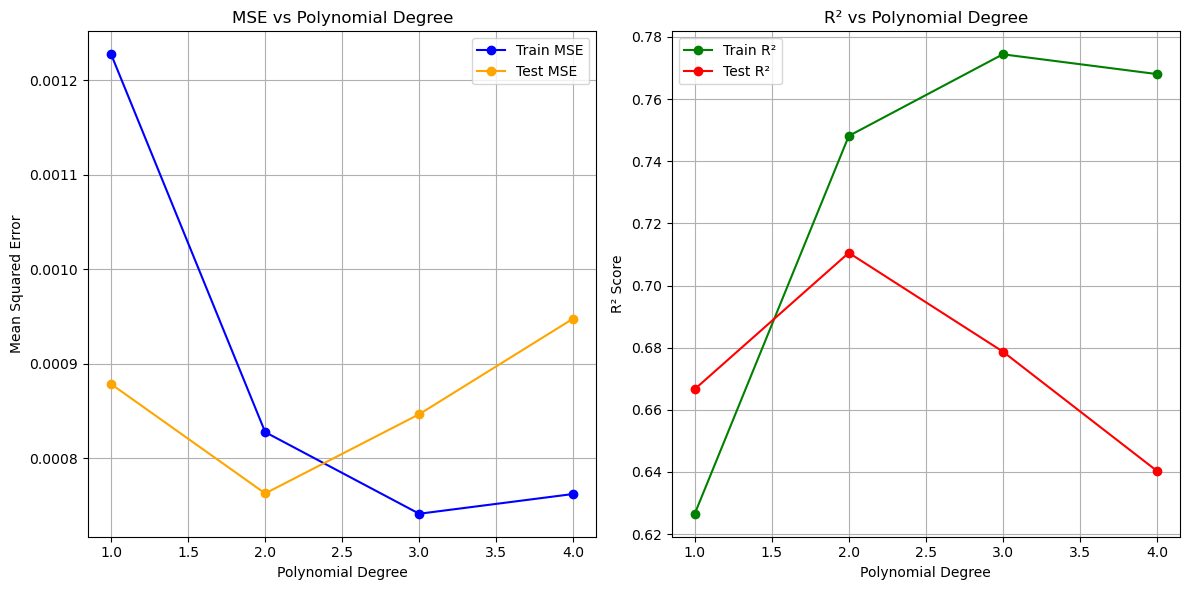

In [168]:
import matplotlib.pyplot as plt

# Lists to store results
mse_train_results = []
mse_test_results = []
r2_train_results = []
r2_test_results = []

poly_degrees = [1, 2, 3, 4]

for d in poly_degrees:
    # Generate polynomial features of the current degree
    df_transformed = feature_engineering(df_encoded, cat_cols, cont_cols, target_col, poly_degree=d)
    
    # Identify significant features using OLS
    significant_features = run_ols(df_transformed, target_col, False)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        df_transformed[significant_features], df_transformed[target_col], test_size=0.2, random_state=42
    )
    
    # Initialize and train the Ridge model
    ridge_model = RidgeModel(alpha=1.0)
    ridge_model.train(X_train, y_train)
    
    # Evaluate the model
    mse_train, mse_test, r2_train, r2_test = ridge_model.evaluate(X_train, y_train, X_test, y_test, False)
    
    # Save metrics
    mse_train_results.append(mse_train)
    mse_test_results.append(mse_test)
    r2_train_results.append(r2_train)
    r2_test_results.append(r2_test)
    

# Plot MSE and R² for training and testing sets
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(poly_degrees, mse_train_results, marker='o', label='Train MSE', color='blue')
plt.plot(poly_degrees, mse_test_results, marker='o', label='Test MSE', color='orange')
plt.title('MSE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(poly_degrees, r2_train_results, marker='o', label='Train R²', color='green')
plt.plot(poly_degrees, r2_test_results, marker='o', label='Test R²', color='red')
plt.title('R² vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


- Right Degree is 2

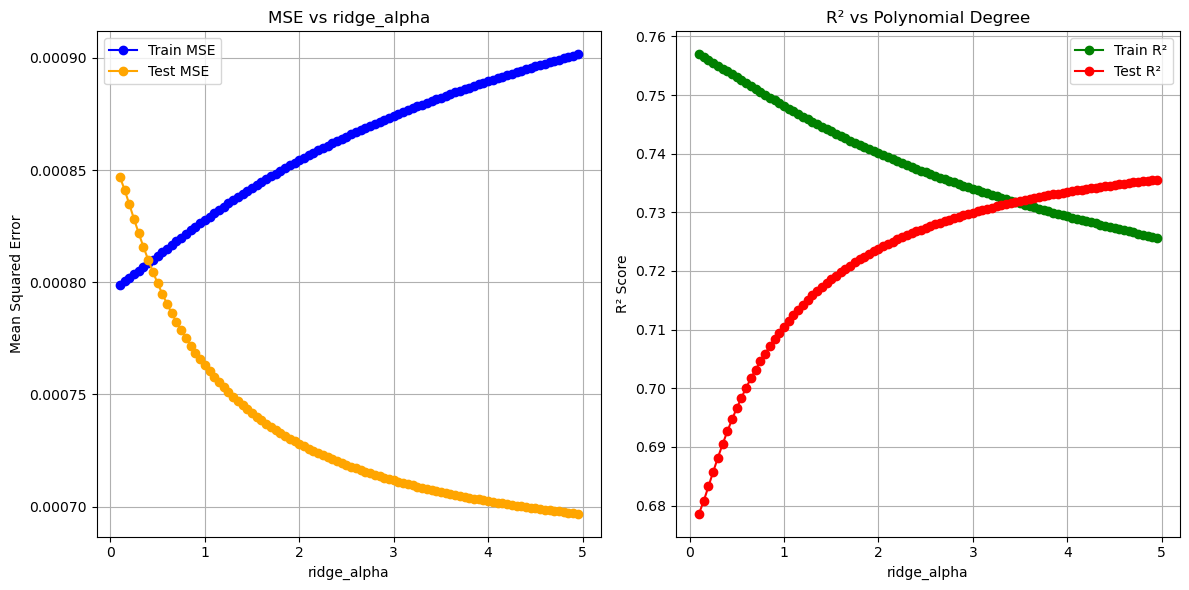

In [169]:
import matplotlib.pyplot as plt

# Lists to store results
mse_train_results = []
mse_test_results = []
r2_train_results = []
r2_test_results = []

ridge_alpha = np.arange(0.1, 5, 0.05)
# ridge_alpha = [10, 100, 1000]

for alpha in ridge_alpha:
    # Generate polynomial features of the current degree
    df_transformed = feature_engineering(df_encoded, cat_cols, cont_cols, target_col, poly_degree=2)
    
    # Identify significant features using OLS
    significant_features = run_ols(df_transformed, target_col, False)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        df_transformed[significant_features], df_transformed[target_col], test_size=0.2, random_state=42
    )
    
    # Initialize and train the Ridge model
    ridge_model = RidgeModel(alpha=alpha)
    ridge_model.train(X_train, y_train)
    
    # Evaluate the model
    mse_train, mse_test, r2_train, r2_test = ridge_model.evaluate(X_train, y_train, X_test, y_test, False)
    
    # Save metrics
    mse_train_results.append(mse_train)
    mse_test_results.append(mse_test)
    r2_train_results.append(r2_train)
    r2_test_results.append(r2_test)
    
# Plot MSE and R² for training and testing sets
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(ridge_alpha, mse_train_results, marker='o', label='Train MSE', color='blue')
plt.plot(ridge_alpha, mse_test_results, marker='o', label='Test MSE', color='orange')
plt.title('MSE vs ridge_alpha')
plt.xlabel('ridge_alpha')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(ridge_alpha, r2_train_results, marker='o', label='Train R²', color='green')
plt.plot(ridge_alpha, r2_test_results, marker='o', label='Test R²', color='red')
plt.title('R² vs Polynomial Degree')
plt.xlabel('ridge_alpha')
plt.ylabel('R² Score')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


- Right Alpha for RidgeModel 3.5

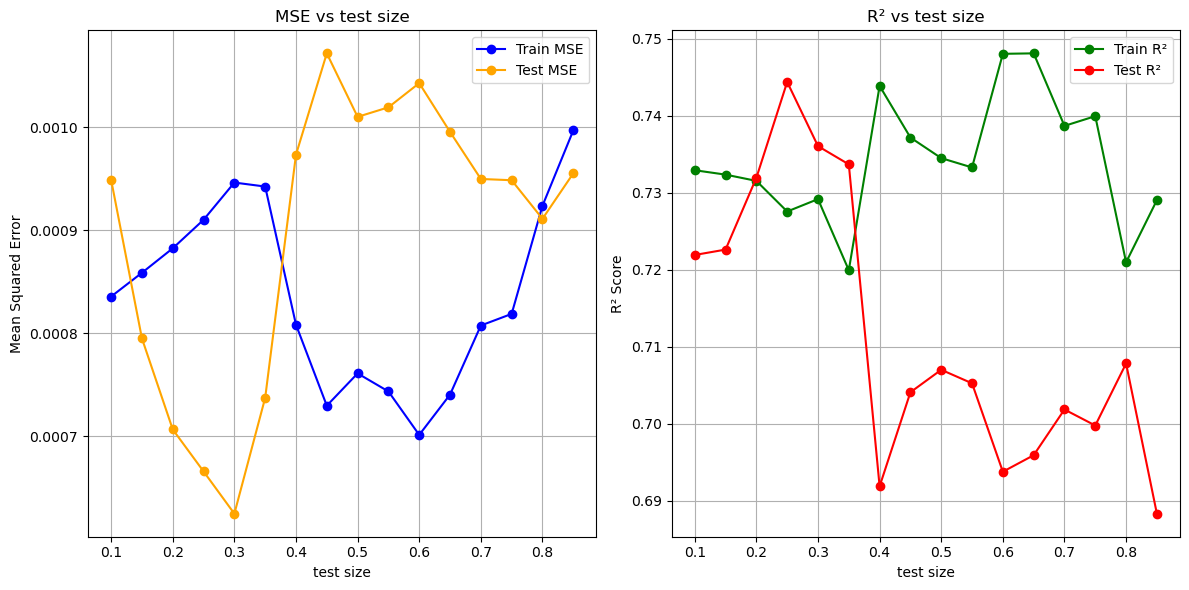

In [170]:
import matplotlib.pyplot as plt

# Lists to store results
mse_train_results = []
mse_test_results = []
r2_train_results = []
r2_test_results = []

test_split = np.arange(0.1, 0.9, 0.05)
# ridge_alpha = [10, 100, 1000]

for t_ in test_split:
    # Generate polynomial features of the current degree
    df_transformed = feature_engineering(df_encoded, cat_cols, cont_cols, target_col, poly_degree=2)
    
    # Identify significant features using OLS
    significant_features = run_ols(df_transformed, target_col, False)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        df_transformed[significant_features], df_transformed[target_col], test_size=t_, random_state=42
    )
    
    # Initialize and train the Ridge model
    ridge_model = RidgeModel(alpha=3.5)
    ridge_model.train(X_train, y_train)
    
    # Evaluate the model
    mse_train, mse_test, r2_train, r2_test = ridge_model.evaluate(X_train, y_train, X_test, y_test, False)
    
    # Save metrics
    mse_train_results.append(mse_train)
    mse_test_results.append(mse_test)
    r2_train_results.append(r2_train)
    r2_test_results.append(r2_test)
    
# Plot MSE and R² for training and testing sets
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(test_split, mse_train_results, marker='o', label='Train MSE', color='blue')
plt.plot(test_split, mse_test_results, marker='o', label='Test MSE', color='orange')
plt.title('MSE vs test size')
plt.xlabel('test size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(test_split, r2_train_results, marker='o', label='Train R²', color='green')
plt.plot(test_split, r2_test_results, marker='o', label='Test R²', color='red')
plt.title('R² vs test size')
plt.xlabel('test size')
plt.ylabel('R² Score')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


- Right test split size 0.35

Train Metrics:
MSE: 0.0009
MAE: 0.0115
R2: 0.7199
Adjusted R2: 0.7184
MAPE: 9716635.2530%

Test Metrics:
MSE: 0.0007
MAE: 0.0108
R2: 0.7337
Adjusted R2: 0.7309
MAPE: 620.9833%



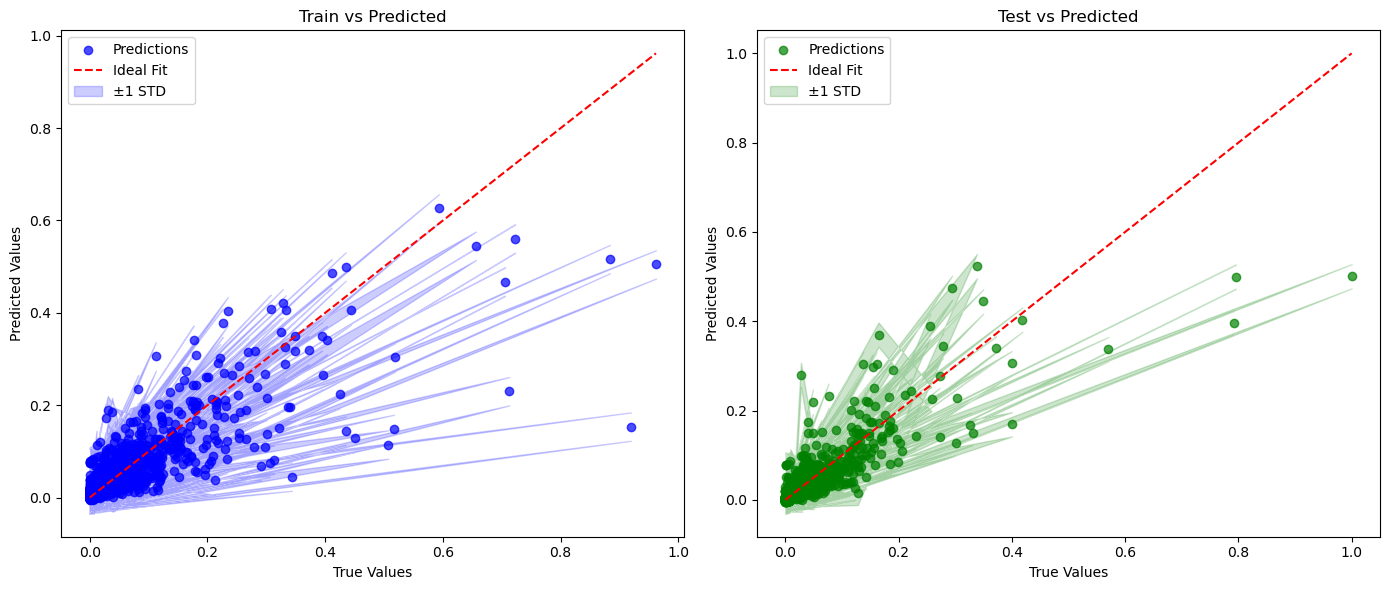

In [172]:
df_transformed = feature_engineering(df_encoded, cat_cols, cont_cols, target_col, poly_degree=2)

significant_features = run_ols(df_transformed, target_col, False)

X_train, X_test, y_train, y_test = train_test_split(
    df_transformed[significant_features], df_transformed[target_col], test_size= 0.35, random_state=42
)

ridge_model = RidgeModel(alpha=3.5)
ridge_model.train(X_train, y_train)

mse_train, mse_test, r2_train, r2_test = ridge_model.evaluate(X_train, y_train, X_test, y_test, True)
n_for_plot = -1

ridge_model.plot_predictions(X_train[:n_for_plot], y_train[:n_for_plot], X_test[:n_for_plot], y_test[:n_for_plot])
